In [1]:
'''
cms_disabled_ind	 Disability Indicator	CMS
cms_dual_eligible_ind	 Dual Eligibility Indicator - eligible for both Medicare and Medicaid	CMS
cms_hospice_ind	 Hospice Indicator	CMS
--- Patients are eligible for hospice care when the attending physician and hospice medical director make a clinical determination
that life expectancy is six months or less, if the disease follows its usual course.
cms_low_income_ind	 Low Income Subsidy Indicator from CMS	CMS
cms_ma_risk_score_nbr	CMS Medicare Advantage Risk Score	CMS
---The purpose of the risk adjustment system is to adequately cover the costs of providing covered benefits for Medicare Advantage enrollees, including those with complex conditions.
cms_partd_ra_factor_amt	CMS Medicare Part D Risk Adjustment Factor Amount	CMS
--- Part D payments made to Part D sponsors, including Medicare AdvantagePrescription Drug plans (MA-PDs) and standalone Prescription Drug Plans (PDPs)
cms_ra_factor_type_cd	CMS Risk Adjustment Factor Type	CMS
cms_risk_adj_payment_rate_a_amt	CMS Risk Adjustment Payment Rate A	CMS
cms_risk_adj_payment_rate_b_amt	CMS  Risk Adjustment Payment Rate B	CMS
cms_risk_adjustment_factor_a_amt	CMS Risk Adjustment Factor A Amount	CMS
cms_rx_risk_score_nbr	CMS Medicare Rx Risk Score	CMS
cms_tot_ma_payment_amt	 Total Medicare Advantage Payment Amount	CMS
cms_tot_partd_payment_amt	 Total PartD Payment Amount	CMS

#CMS conditions indicator
cmsd2_can_unc_neo/plycyth/myelo_ind	 Binary indicator for each of the CMS Level 2 diagnosis categories present in the reference table
cmsd2_eye_blindness_ind	 Binary indicator for each of the CMS Level 2 diagnosis categories present in the reference table
cmsd2_gus_m_genital_ind	 Binary indicator for each of the CMS Level 2 diagnosis categories present in the reference table
cmsd2_men_mad_ind	 Binary indicator for each of the CMS Level 2 diagnosis categories present in the reference table
cmsd2_men_men_substance_ind	 Binary indicator for each of the CMS Level 2 diagnosis categories present in the reference table
cmsd2_mus_polyarthropath_ind	 Binary indicator for each of the CMS Level 2 diagnosis categories present in the reference table
cmsd2_mus_spondylopath_ind	 Binary indicator for each of the CMS Level 2 diagnosis categories present in the reference table
cmsd2_skn_radiation_ind	 Binary indicator for each of the CMS Level 2 diagnosis categories present in the reference table
cmsd2_sns_general_ind	 Binary indicator for each of the CMS Level 2 diagnosis categories present in the reference table

---CMS risk adjusts Part C payments made to Medicare
Advantage (MA) plans and Program of All Inclusive Care for The Elderly (PACE)
organizations, and
'''

'\ncms_disabled_ind\t Disability Indicator\tCMS\ncms_dual_eligible_ind\t Dual Eligibility Indicator - eligible for both Medicare and Medicaid\tCMS\ncms_hospice_ind\t Hospice Indicator\tCMS\n--- Patients are eligible for hospice care when the attending physician and hospice medical director make a clinical determination\nthat life expectancy is six months or less, if the disease follows its usual course.\ncms_low_income_ind\t Low Income Subsidy Indicator from CMS\tCMS\ncms_ma_risk_score_nbr\tCMS Medicare Advantage Risk Score\tCMS\n---The purpose of the risk adjustment system is to adequately cover the costs of providing covered benefits for Medicare Advantage enrollees, including those with complex conditions.\ncms_partd_ra_factor_amt\tCMS Medicare Part D Risk Adjustment Factor Amount\tCMS\n--- Part D payments made to Part D sponsors, including Medicare AdvantagePrescription Drug plans (MA-PDs) and standalone Prescription Drug Plans (PDPs)\ncms_ra_factor_type_cd\tCMS Risk Adjustment Fac

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
df= pd.read_csv('2020_Competition_Training (1).csv')
# df = pd.read_csv('2020_Competition_Holdout .csv')
# df['transportation_issues'] = 0

/root/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (80,193) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.shape

(69572, 826)

In [4]:
def logistic(X_train, X_test,y_train, y_test):
    logistic_regression= LogisticRegression()
    logistic_regression.fit(X_train,y_train)
    y_pred_test=logistic_regression.predict(X_test)
    y_pred_train=logistic_regression.predict(X_train)
    return logistic_regression,y_pred_train, y_pred_test
    

In [5]:
def xgboost_fn(X_train, X_test, y_train, y_test):
    from sklearn import metrics
    import matplotlib.pyplot as plt
    # Hyperparameter tuning grid
    params = {'min_child_weight': [5],
            'gamma': [1.5],
            'subsample': [0.8],
            'colsample_bytree': [0.8],
            'max_depth': [4]}

    from sklearn.model_selection import GridSearchCV
    from xgboost.sklearn import XGBClassifier
    # Initialize XGBoost model, use growth tree algorithm similar to lightgbm
    bst = XGBClassifier(n_jobs=-1,grow_policy='lossguide',tree_method ='hist',n_estimators=150)
    # Gridsearch on parameter grid, use AUC to determine the best model
    cv = GridSearchCV(bst,params,'roc_auc',-1, verbose=10)
    # Fit model on the training data, track logloss on training and testing set
    cv.fit(X_train, y_train,eval_metric='logloss',eval_set=[(X_train,y_train),(X_test,y_test)],verbose=False)

    import cf_matrix
    from cf_matrix import make_confusion_matrix
    from sklearn.metrics import confusion_matrix,accuracy_score

    y_xg_pred_test = cv.best_estimator_.predict(X_test)
    y_xg_pred_train = cv.best_estimator_.predict(X_train)

    print(metrics.accuracy_score(y_test, y_xg_pred_test))
    print(metrics.accuracy_score(y_train, y_xg_pred_train))


    cm = confusion_matrix(y_test, y_xg_pred_test)
    plt.figure(figsize=(20,15))
    sns.set(font_scale=1.4) # for label size
    make_confusion_matrix(cm, group_names=['no- issue','issue'],categories=['no-issue','issue'], cmap='binary')
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) 
    plt.show()

    import joblib

    # Print out the best parameters
    cv.best_params_

    #save model
    joblib.dump(cv.best_estimator_, 'xgb.model')


    #load saved model
    xgb = joblib.load('xgb.model')


    import sklearn.metrics as metrics
    # calculate the fpr and tpr for all thresholds of the classification
    probs = xgb.predict_proba(X_test)
    preds = probs[:,1]
    # preds = [1]*17119
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


    # retrieve performance metrics
    results = xgb.evals_result()
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss');

    # Feature importance plot
    feature_importance = pd.DataFrame({'feature':xgb.get_booster().feature_names, 'importance':xgb.feature_importances_}).sort_values('importance',ascending=False).reset_index().drop(columns='index')
    fig, ax = plt.subplots()
    fig.set_size_inches(8.27,15)
    plt.title('Feature Importance Plot')
    sns.barplot(x='importance',y='feature',ax=ax,data=feature_importance[:50])
    
    return feature_importance
    


In [6]:
def train_test_split_fn(df):
    y = df['transportation_issues']
    X = df.drop(['transportation_issues','person_id_syn'],axis=1)

    
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn import metrics
    import seaborn as sn
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import StandardScaler

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

    X_train.reset_index(inplace=True,drop=True)
    X_test.reset_index(inplace=True,drop=True)
    y_train.reset_index(inplace=True,drop=True)
    y_test.reset_index(inplace=True,drop=True)
    
    return X_train, X_test, y_train, y_test

In [7]:
def label_encoder_fn(df, categorical_columns, numerical_columns):
    from sklearn.preprocessing import LabelEncoder
    labelencoder = LabelEncoder()
    from collections import defaultdict
    d = defaultdict(LabelEncoder)
    from collections import defaultdict
    d = defaultdict(LabelEncoder)
    df_cat = df[categorical_columns].apply(lambda x: d[x.name].fit_transform(x))
    df_num = df[numerical_columns]
    df_all = pd.concat([df_num,df_cat],axis=1)
    
    return df_all

In [8]:
#Centers for Medicare and Medicaid Services
CMS_df= df.filter(items=['person_id_syn',
'transportation_issues',
'cms_disabled_ind',
'cms_dual_eligible_ind',
'cms_hospice_ind',
'cms_low_income_ind',
'cms_ma_risk_score_nbr',
'cms_partd_ra_factor_amt',
'cms_ra_factor_type_cd',
'cms_risk_adj_payment_rate_a_amt',
'cms_risk_adj_payment_rate_b_amt',
'cms_risk_adjustment_factor_a_amt',
'cms_rx_risk_score_nbr',
'cms_tot_ma_payment_amt',
'cms_tot_partd_payment_amt',
'cmsd2_can_unc_neo/plycyth/myelo_ind',
'cmsd2_eye_blindness_ind',
'cmsd2_gus_m_genital_ind',
'cmsd2_men_mad_ind',
'cmsd2_men_men_substance_ind',
'cmsd2_mus_polyarthropath_ind',
'cmsd2_mus_spondylopath_ind',
'cmsd2_skn_radiation_ind',
'cmsd2_sns_general_ind'
])


# Execute for Train

In [9]:
na_columns = ['cms_ma_risk_score_nbr',
 'cms_partd_ra_factor_amt',
 'cms_risk_adj_payment_rate_a_amt',
 'cms_risk_adj_payment_rate_b_amt',
 'cms_risk_adjustment_factor_a_amt',
 'cms_rx_risk_score_nbr',
 'cms_tot_ma_payment_amt',
 'cms_tot_partd_payment_amt']

na_impute_mean = []

    
CMS_issues_df = CMS_df[CMS_df.transportation_issues ==1]
CMS_no_issues_df = CMS_df[CMS_df.transportation_issues ==0]

for i in na_columns:
    print(CMS_df[i].mean())
    na_impute_mean.append(CMS_df[i].mean())
    CMS_issues_df[i]=CMS_issues_df[i].fillna(CMS_issues_df[i].mean())

CMS_df = pd.concat([CMS_issues_df, CMS_no_issues_df])

CMS_df['cms_ra_factor_type_cd'] = CMS_df.cms_ra_factor_type_cd.astype('category')
CMS_df.cms_ra_factor_type_cd.fillna(CMS_df.cms_ra_factor_type_cd.mode()[0])
CMS_df.reset_index(inplace=True,drop=True)

1.1214192097264886
1.0718098482313876
398.0525458799205
506.8921631065604
1.1197219732304942
1.0492775321696062
999.8885503327182
145.1992061924593


<ipython-input-9-e33394487f2e>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CMS_issues_df[i]=CMS_issues_df[i].fillna(CMS_issues_df[i].mean())


# Execute for test

In [10]:
# na_columns = ['cms_ma_risk_score_nbr',
#  'cms_partd_ra_factor_amt',
#  'cms_risk_adj_payment_rate_a_amt',
#  'cms_risk_adj_payment_rate_b_amt',
#  'cms_risk_adjustment_factor_a_amt',
#  'cms_rx_risk_score_nbr',
#  'cms_tot_ma_payment_amt',
#  'cms_tot_partd_payment_amt']



# na_impute_mean = [1.1214192097264886,
#  1.0718098482313876,
#  398.0525458799205,
#  506.8921631065604,
#  1.1197219732304942,
#  1.0492775321696062,
#  999.8885503327182,
#  145.1992061924593]

# na_impute_cms_ra_factor_type_cd = 'CN'

# for i,j in zip(na_columns, na_impute_mean):
#     CMS_df[i]=CMS_df[i].fillna(j)

# CMS_df['cms_ra_factor_type_cd'] = CMS_df.cms_ra_factor_type_cd.fillna(na_impute_cms_ra_factor_type_cd)

In [11]:


categorical_columns = [s for s in CMS_df if '_ind' in s]
# categorical_columns.append('cms_ra_factor_type_cd')
categorical_columns.append('transportation_issues')


CMS_df['cms_ra_factor_type_cd'].replace('*',np.NaN,inplace=True)

In [12]:
for i in categorical_columns:
    CMS_df[i] = CMS_df[i].astype('category')

In [13]:
numeric_columns = CMS_df.select_dtypes(exclude='category').columns

In [14]:
for i in categorical_columns:
    print(i)
#     prov_df[i] = prov_df[i].astype('category')
    df_one = CMS_df[CMS_df[i]==1]
    print("percentage of ",i, 'as Yes is', df_one.shape[0]/CMS_df.shape[0])
    print("percentage of YES and Transportation Issue", df_one[df_one.transportation_issues ==1].shape[0]/CMS_df.shape[0])
    print('-'*30)
    
level_1_col  = [s for s in CMS_df.columns if 'cms_' in s]
level_1_col = [s for s in level_1_col if '_ind' in s]

level_2_col = [s for s in CMS_df.columns if 'cmsd2' in s]
level_2_col = [s for s in level_2_col if '_ind' in s]



CMS_df['CMS_ind_sum'] = CMS_df[level_1_col].sum(axis=1)
CMS_df.loc[CMS_df.CMS_ind_sum > 0, 'CMS_yes_no'] =1
CMS_df['CMS_yes_no'] = CMS_df.CMS_yes_no.fillna(0)
CMS_df['CMS_yes_no'] = CMS_df['CMS_yes_no'].astype('category')

CMS_df['CMS2_ind_sum'] = CMS_df[level_2_col].sum(axis=1)
CMS_df.loc[CMS_df.CMS2_ind_sum > 0, 'CMS2_yes_no'] =1
CMS_df['CMS2_yes_no'] = CMS_df.CMS2_yes_no.fillna(0)
CMS_df['CMS2_yes_no'] = CMS_df['CMS2_yes_no'].astype('category')


cms_disabled_ind
percentage of  cms_disabled_ind as Yes is 0.30207554763410566
percentage of YES and Transportation Issue 0.07002817225320532
------------------------------
cms_dual_eligible_ind
percentage of  cms_dual_eligible_ind as Yes is 0.16444834128672453
percentage of YES and Transportation Issue 0.04471626516414649
------------------------------
cms_hospice_ind
percentage of  cms_hospice_ind as Yes is 0.0005174495486690048
percentage of YES and Transportation Issue 7.18679928706951e-05
------------------------------
cms_low_income_ind
percentage of  cms_low_income_ind as Yes is 0.23756683723336974
percentage of YES and Transportation Issue 0.06077157477145978
------------------------------
cmsd2_can_unc_neo/plycyth/myelo_ind
percentage of  cmsd2_can_unc_neo/plycyth/myelo_ind as Yes is 0.09316966595756913
percentage of YES and Transportation Issue 0.00983154142471109
------------------------------
cmsd2_eye_blindness_ind
percentage of  cmsd2_eye_blindness_ind as Yes is 0.0822169

In [15]:
def data_viz(df_visualize):
    df_visualize = df_visualize.groupby(['transportation_issues']).sum().transpose()
    df_visualize.reset_index(drop=False,inplace=True)
    df_visualize.columns = ['sum_columns','no_issues','issues']

    df_visualize = df_visualize.melt(['sum_columns'])
    
    df_visualize['avg_value'] = 0

    for index, row in df_visualize.iterrows():
        if row['variable'] == 'no_issues':
            df_visualize.loc[index,'avg_value'] = row['value']/59375
        else:
            df_visualize.loc[index,'avg_value'] = row['value']/10197
    
    return df_visualize

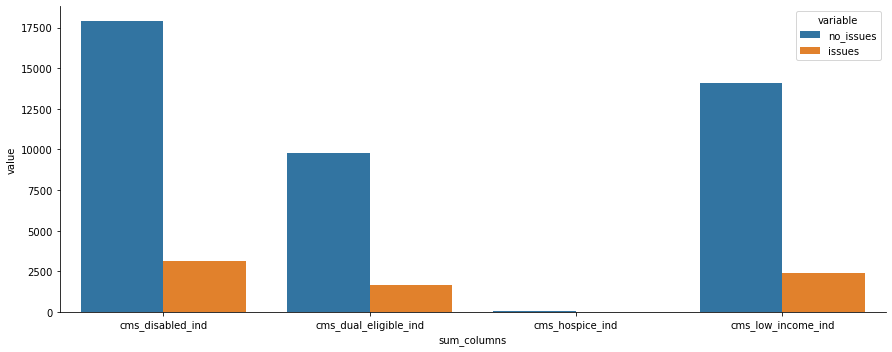

In [16]:
CMS_df_encoded = label_encoder_fn(CMS_df, categorical_columns, numeric_columns)
# level_1_col.append('CMS_ind_sum')
df_viz = pd.concat([CMS_df_encoded[level_1_col],df[['transportation_issues']]],axis=1)

df_viz_1 = data_viz(df_viz)

ax = sns.catplot(x="sum_columns", y="value", hue="variable", kind="bar",height=5, 
            aspect=2.5, data=df_viz_1,legend_out=False)

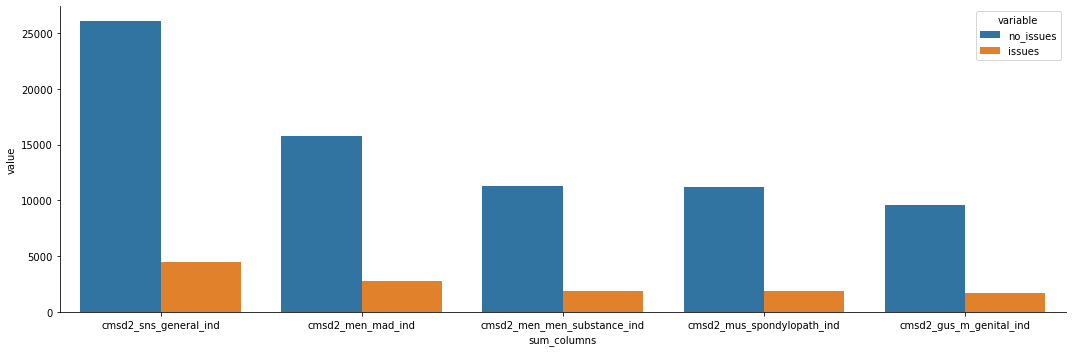

In [46]:
CMS_df_encoded = label_encoder_fn(CMS_df, categorical_columns, numeric_columns)
# level_1_col.append('CMS_ind_sum')
df_viz = pd.concat([CMS_df_encoded[level_2_col],df[['transportation_issues']]],axis=1)


df_viz = df_viz.groupby(['transportation_issues']).sum().transpose()
df_viz.reset_index(drop=False,inplace=True)
df_viz.columns = ['sum_columns','no_issues','issues']
df_viz['total'] = df_viz.no_issues + df_viz.issues
df_viz = df_viz.sort_values('total',ascending=False)
df_viz = df_viz.head(5)
df_viz.drop('total',inplace=True, axis=1)
df_viz_1 = df_viz.melt(['sum_columns'])
# df_viz_1.sort_values('value',ascending=False)

# df_viz_1 = data_viz(df_viz)
df_viz_1['avg_value'] = 0

for index, row in df_viz_1.iterrows():
    if row['variable'] == 'no_issues':
        df_viz_1.loc[index,'avg_value'] = row['value']/59375
    else:
        df_viz_1.loc[index,'avg_value'] = row['value']/10197

ax = sns.catplot(x="sum_columns", y="value", hue="variable", kind="bar",height=5, 
            aspect=3, data=df_viz_1,legend_out=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/root/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass scoring=roc_auc, n_jobs=-1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.3s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


0.848214799057092
0.8612276969662125


<Figure size 1440x1080 with 0 Axes>

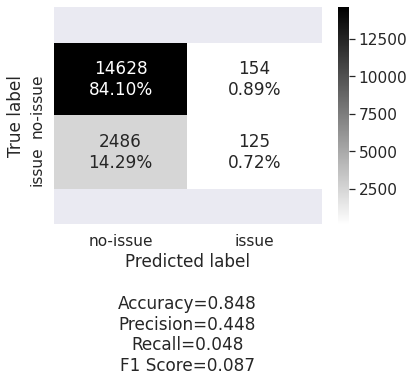

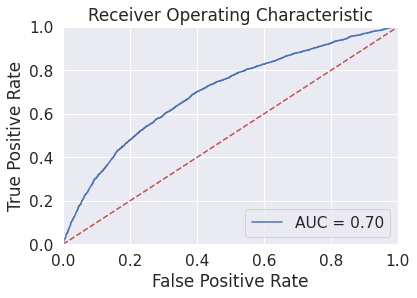

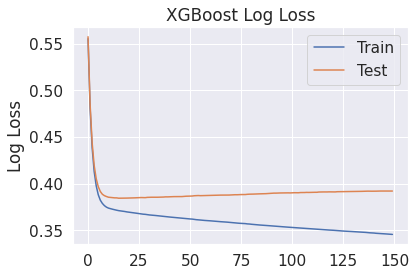

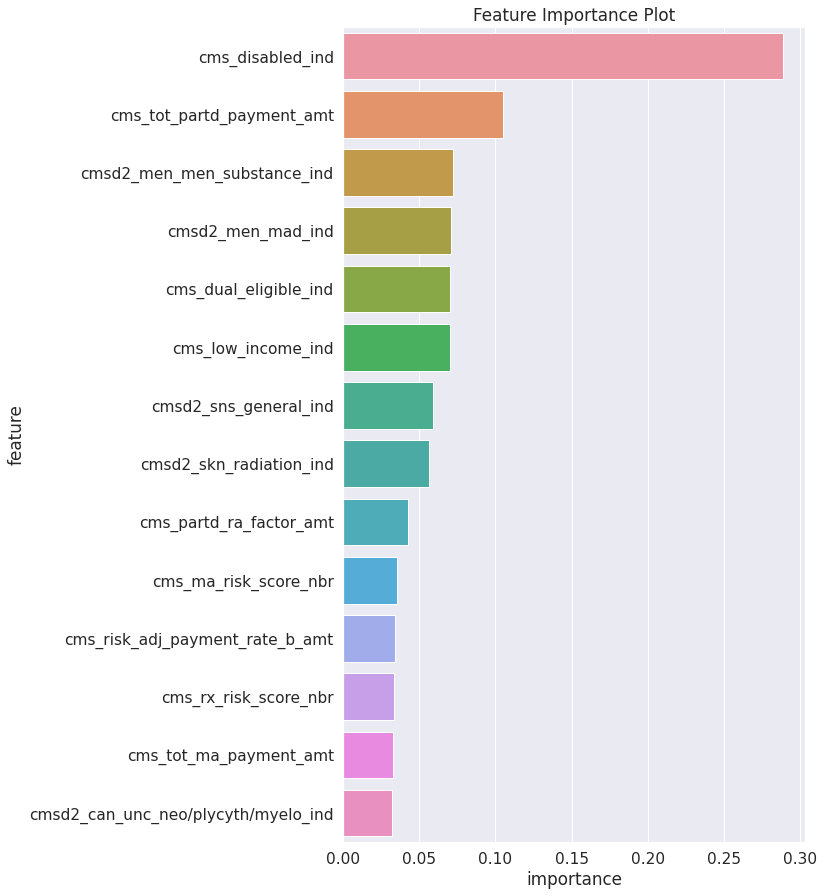

In [14]:
# categorical_columns.append('cms_ra_factor_type_cd')

CMS_df_encoded = label_encoder_fn(CMS_df, categorical_columns, numeric_columns)

X_train, X_test, y_train, y_test = train_test_split_fn(CMS_df_encoded)


top_featured_columns=['cms_disabled_ind',
 'cms_tot_partd_payment_amt',
 'cms_low_income_ind',
 'cms_rx_risk_score_nbr',
 'cmsd2_men_men_substance_ind',
 'cmsd2_men_mad_ind',
 'cmsd2_skn_radiation_ind',
 'cmsd2_sns_general_ind',
 'cms_dual_eligible_ind',
 'cms_risk_adj_payment_rate_b_amt',
 'cms_partd_ra_factor_amt',
 'cmsd2_can_unc_neo/plycyth/myelo_ind',
 'cms_tot_ma_payment_amt',
 'cms_ma_risk_score_nbr']

X_train=X_train[top_featured_columns]
X_test=X_test[top_featured_columns]


feature_importance = xgboost_fn(X_train, X_test, y_train, y_test)

In [91]:
top_featured_columns = list(feature_importance[feature_importance.importance>0.025].feature)

top_featured_columns.append('transportation_issues')
top_featured_columns.append('person_id_syn')


In [50]:
top_featured_columns=['cms_disabled_ind',
 'cms_tot_partd_payment_amt',
 'cms_low_income_ind',
 'cms_rx_risk_score_nbr',
 'cmsd2_men_men_substance_ind',
 'cmsd2_men_mad_ind',
 'cmsd2_skn_radiation_ind',
 'cmsd2_sns_general_ind',
 'cms_dual_eligible_ind',
 'cms_risk_adj_payment_rate_b_amt',
 'cms_partd_ra_factor_amt',
 'cmsd2_can_unc_neo/plycyth/myelo_ind',
 'cms_tot_ma_payment_amt',
 'cms_ma_risk_score_nbr','person_id_syn']

# For train

In [32]:
# final_df = CMS_df[top_featured_columns]
# final_df = final_df.rename(columns = {'person_id_syn':'person_id_syn_cms','cmsd2_can_unc_neo/plycyth/myelo_ind':'cmsd2_can_unc_neo'})
# final_df.to_pickle("df_suraj_cms.pkl")

# for Test

In [51]:
final_test_df = CMS_df[top_featured_columns]

final_test_df = final_test_df.rename(columns = {'person_id_syn':'person_id_syn_cms','cmsd2_can_unc_neo/plycyth/myelo_ind':'cmsd2_can_unc_neo'})
#final_test_df.drop('transportation_issues',axis=1).to_pickle("df_suraj_test_cms.pkl")
final_test_df.to_pickle("df_suraj_test_cms.pkl")

In [21]:
final_df.drop('transportation_issues',axis=1).to_csv("log_df_cms.csv",index=False)

In [18]:
#df_viz_1.to_csv("df_viz_cms.csv")

In [17]:
df_viz_1.head()

,sum_columns,variable,value,avg_value
0,cms_disabled_ind,no_issues,17904,0.301541
1,cms_dual_eligible_ind,no_issues,9759,0.164362
2,cms_hospice_ind,no_issues,32,0.000539
3,cms_low_income_ind,no_issues,14117,0.237760
4,cms_disabled_ind,issues,3112,0.305188


In [ ]:
CMS_df.head(5)

In [ ]:
CMS_df.isna().sum()

In [ ]:
CMS_df['cms_ra_factor_type_cd'].replace('*','',inplace=True)
df_no_issue = CMS_df[CMS_df.transportation_issues == 0]
print(df_no_issue.shape)
df_no_issue = df_no_issue.dropna()
print("after dropping NA values",df_no_issue.shape)
df_issue = CMS_df[CMS_df.transportation_issues == 1]
print(df_issue.shape)
df_issue = df_issue.dropna()
print("after dropping NA values",df_issue.shape)
# df_issue.isna().sum()

In [ ]:
CMS_df.shape

In [ ]:
CMS_df.dtypes

In [ ]:
CMS_df['transportation_issues'] = CMS_df.transportation_issues.astype('category')
CMS_df['cms_disabled_ind'] = CMS_df.cms_disabled_ind.astype('category')
CMS_df['cms_dual_eligible_ind'] = CMS_df.cms_dual_eligible_ind.astype('category')
CMS_df['cms_hospice_ind'] = CMS_df.cms_hospice_ind.astype('category')
CMS_df['cms_low_income_ind'] = CMS_df.cms_low_income_ind.astype('category')
CMS_df['cmsd2_eye_blindness_ind'] = CMS_df.cmsd2_eye_blindness_ind.astype('category')
CMS_df['cmsd2_gus_m_genital_ind'] = CMS_df.cmsd2_gus_m_genital_ind.astype('category')
CMS_df['cmsd2_men_mad_ind'] = CMS_df.cmsd2_men_mad_ind.astype('category')
CMS_df['cmsd2_men_men_substance_ind'] = CMS_df.cmsd2_men_men_substance_ind.astype('category')
CMS_df['cmsd2_mus_polyarthropath_ind'] = CMS_df.cmsd2_mus_polyarthropath_ind.astype('category')
CMS_df['cmsd2_mus_spondylopath_ind'] = CMS_df.cmsd2_mus_spondylopath_ind.astype('category')
CMS_df['cmsd2_skn_radiation_ind'] = CMS_df.cmsd2_skn_radiation_ind.astype('category')
CMS_df['cmsd2_sns_general_ind'] = CMS_df.cmsd2_sns_general_ind.astype('category')
CMS_df['cmsd2_can_unc_neo/plycyth/myelo_ind'] = CMS_df['cmsd2_can_unc_neo/plycyth/myelo_ind'].astype('category')

In [ ]:
CMS_df.dtypes

In [ ]:
CMS_df.head(2)

In [ ]:
CMS_df=CMS_df.dropna()

In [ ]:
CMS_df.columns

In [ ]:
#CMS_df.isna().sum()
CMS_df['Total_Ind']=
cms_disabled_ind+                    0
cms_dual_eligible_ind+                 0
cms_hospice_ind +                       0
cms_low_income_ind+

In [ ]:
for i in CMS_df.columns:
    if i=='person_id_syn':
            continue
    if i=='transportation_issues':
            continue
#     if i=='rev_cms_total_ind':
#         df_one = rev_df[rev_df[i] ==4]#[i ]==3]
#         print("percentage of patients using",i,df_one.shape[0]/rev_df.shape[0])
#         print('percentage of patients using',i,'and Transportation Issue', df_one[df_one.transportation_issues ==1].shape[0]/df_one.shape[0])
#     else:
    try:
            df_one = CMS_df[CMS_df[i] !=0]
            print("percentage of patients using",i,df_one.shape[0]/CMS_df.shape[0])
            print('percentage of patients using',i,'and Transportation Issue', df_one[df_one.transportation_issues ==1].shape[0]/df_one.shape[0])
    except:
            continue    
    
#evry variable has more than 10%. taking all.

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
from collections import defaultdict

In [ ]:
d = defaultdict(LabelEncoder)
# Encoding the variable
#CMS_df['cms_ra_factor_type_cd'] = CMS_df['cms_ra_factor_type_cd'].apply(lambda x: d[x.name].fit_transform(x))
#CMS_df['cms_ra_factor_type_cd'] = LabelEncoder().fit(CMS_df['cms_ra_factor_type_cd']).transform(CMS_df['cms_ra_factor_type_cd'])

In [ ]:
#CMS_new_df=

In [ ]:
CMS_df_no_issue = CMS_df[CMS_df.transportation_issues == 0]
CMS_df_issue = CMS_df[CMS_df.transportation_issues == 1]
#print(CMS_df_issue.shape)
CMS_df_no_issue_sample = CMS_df_no_issue.sample(n=8886)
CMS_new_df = pd.concat([CMS_df_no_issue_sample, CMS_df_issue])

In [ ]:
CMS_new_df.shape

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
y = CMS_new_df['transportation_issues']
X = CMS_new_df.drop(columns=['transportation_issues','person_id_syn','cms_ra_factor_type_cd'])
#X = CMS_new_df[['cmsd2_eye_blindness_ind','cms_hospice_ind']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [ ]:
CMS_df.drop(['transportation_issues','cms_ra_factor_type_cd'],axis=1).to_pickle('df_cms_suraj.pkl')

In [ ]:
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred_test=logistic_regression.predict(X_test)
y_pred_train=logistic_regression.predict(X_train)

In [ ]:
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_test))
print('Accuracy: ',metrics.accuracy_score(y_train, y_pred_train))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
RF_clf = RandomForestClassifier(n_estimators=300,max_depth=10)
RF_clf.fit(X_train, y_train)

In [ ]:
y_rf_pred_test = RF_clf.predict(X_test)
y_rf_pred_train = RF_clf.predict(X_train)

print(classification_report(y_test, y_rf_pred_test))
print(classification_report(y_train, y_rf_pred_train))

print(metrics.accuracy_score(y_test, y_rf_pred_test))
print(metrics.accuracy_score(y_train, y_rf_pred_train))

In [ ]:
## stuff

In [ ]:
# L=CMS_df.columns.to_list()
# #type(L[0])
# for i in L:
#     CMS_df.groupby([i, 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
#     CMS_df.groupby(['transportation_issues',i]).size().unstack().plot(kind='bar', stacked=False)
#     print('1')

### cms_dual_eligible_ind

In [ ]:
CMS_df.groupby(['cms_dual_eligible_ind', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_dual_eligible_ind']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_dual_eligible_ind==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])
# more than 30% of people with dual eligibility indicator are facing transportation issues
print(CMS_df[CMS_df[CMS_df.cms_dual_eligible_ind==1]]['transportation_issues'].shape[0])

### cms_disabled_ind

In [ ]:
CMS_df.groupby(['cms_disabled_ind', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_disabled_ind']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_disabled_ind==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])


### cms_hospice_ind

In [ ]:
CMS_df.groupby(['cms_hospice_ind', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_hospice_ind']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_hospice_ind==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_hospice_ind==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])

### cms_low_income_ind

In [ ]:
CMS_df.groupby(['cms_low_income_ind', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_low_income_ind']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_low_income_ind==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_low_income_ind==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])

### cms_ma_risk_score_nbr

In [ ]:
CMS_df.groupby(['cms_ma_risk_score_nbr', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_ma_risk_score_nbr']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_ma_risk_score_nbr==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_ma_risk_score_nbr==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])

### cms_partd_ra_factor_amt


In [ ]:
CMS_df.groupby(['cms_partd_ra_factor_amt', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_partd_ra_factor_amt']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_partd_ra_factor_amt==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_partd_ra_factor_amt==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])

### cms_ra_factor_type_cd


In [ ]:
CMS_df.groupby(['cms_ra_factor_type_cd', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_ra_factor_type_cd']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_hospice_ind==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_hospice_ind==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])

### cms_risk_adj_payment_rate_a_amt


In [ ]:
CMS_df.groupby(['cms_risk_adj_payment_rate_a_amt', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_risk_adj_payment_rate_a_amt']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_hospice_ind==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_hospice_ind==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])

### cms_risk_adj_payment_rate_b_amt


In [ ]:
CMS_df.groupby(['cms_risk_adj_payment_rate_b_amt', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_risk_adj_payment_rate_b_amt']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_hospice_ind==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_hospice_ind==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])

### cms_risk_adjustment_factor_a_amt


In [ ]:
CMS_df.groupby(['cms_risk_adjustment_factor_a_amt', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_risk_adjustment_factor_a_amt']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_risk_adjustment_factor_a_amt==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_risk_adjustment_factor_a_amt==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])

### cms_rx_risk_score_nbr


In [ ]:
CMS_df.groupby(['cms_rx_risk_score_nbr', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_rx_risk_score_nbr']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_rx_risk_score_nbr==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_rx_risk_score_nbr==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])

### cms_tot_ma_payment_amt


In [ ]:
CMS_df.groupby(['cms_tot_ma_payment_amt', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_tot_ma_payment_amt']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_tot_ma_payment_amt==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_tot_ma_payment_amt==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])

### cms_tot_partd_payment_amt

In [ ]:
CMS_df.groupby(['cms_tot_partd_payment_amt', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_tot_partd_payment_amt']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_hospice_ind==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_hospice_ind==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])

In [ ]:
CMS_df.groupby(['cms_tot_partd_payment_amt', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_tot_partd_payment_amt']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_hospice_ind==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_hospice_ind==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])

In [ ]:
CMS_df.groupby(['cms_tot_partd_payment_amt', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_tot_partd_payment_amt']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_hospice_ind==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_hospice_ind==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])

In [ ]:
CMS_df.groupby(['cms_tot_partd_payment_amt', 'transportation_issues']).size().unstack().plot(kind='bar', stacked=False)
CMS_df.groupby(['transportation_issues','cms_tot_partd_payment_amt']).size().unstack().plot(kind='bar', stacked=False)
print(CMS_df[CMS_df.cms_hospice_ind==0].transportation_issues.value_counts())
print(CMS_df[CMS_df.cms_hospice_ind==1].transportation_issues.value_counts())
#print((CMS_df[CMS_df.cms_disabled_ind==1].transportation_issues.value_counts()[0])/(CMS_df[CMS_df.cms_dual_eligible_ind==1].transportation_issues.value_counts())[1])